In [1]:
pip install pandas numpy scikit-learn catboost tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd  # Import necessary libraries
import numpy as np  # Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV  # Split the data into training and testing sets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report  # Calculate the accuracy of the model
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf  # Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns  # Import necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt  # Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

In [5]:
directory = r'C:\Users\gilad\Desktop\bat_test\star_classification.csv'
data = pd.read_csv(directory)

In [6]:
data.drop(columns = ['obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'], inplace = True)

In [7]:
features = data.columns.drop('class')
features

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'redshift'], dtype='object')

In [8]:
#target = data['class']
#target = pd.get_dummies(target)

In [9]:
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(data['class'])

data['class'] = encoded_labels
target = data['class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('class', axis = 1), target, test_size=0.2, random_state=42)  # Split the data into training and testing sets

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np  # Import necessary libraries
from tqdm.notebook import tqdm
import time  # Import necessary libraries

# Define parameters for search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Function to evaluate the model with progress tracking
def evaluate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    return np.mean(scores)

# Create base Random Forest model
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV instead of GridSearchCV to speed up the process
n_iter = 20  # Number of iterations for random search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=n_iter, cv=5, verbose=0, random_state=42, n_jobs=-1)

# Track progress
start_time = time.time()
with tqdm(total=n_iter, desc="Optimizing Random Forest") as pbar:
    for i in range(n_iter):
        # Generate random parameters
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        
        # Create and evaluate the model
        model = RandomForestClassifier(**params, random_state=42)  # Initialize the machine learning model
        score = evaluate_model(model, X_train, y_train)
        
        # Update best result
        if not hasattr(random_search, 'best_score_') or score > random_search.best_score_:
            random_search.best_score_ = score
            random_search.best_params_ = params
        
        # Update progress bar
        pbar.update(1)
        pbar.set_postfix({'Best Score': f"{random_search.best_score_:.4f}"})

# Print results
print(f"\nOptimization completed in {time.time() - start_time:.2f} seconds")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")

# Create optimized model
rf_optimized = RandomForestClassifier(**random_search.best_params_, random_state=42)
rf_optimized.fit(X_train, y_train)  # Train the model on the training data

# Evaluate on test set
y_pred_rf = rf_optimized.predict(X_test)  # Make predictions using the trained model
print(f"Accuracy on test set: {accuracy_score(y_test, y_pred_rf):.4f}")  # Calculate the accuracy of the model

Optimizing Random Forest:   0%|          | 0/20 [00:00<?, ?it/s]


Optimization completed in 636.04 seconds
Best parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best score: 0.9788
Accuracy on test set: 0.9778


In [13]:
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
catboost_model.fit(X_train, y_train)  # Train the model on the training data
y_pred_catboost = catboost_model.predict(X_test)  # Make predictions using the trained model
print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_catboost))  # Calculate the accuracy of the model

CatBoost Accuracy: 0.97775


In [14]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)  # Train the model on the training data
y_pred_svm = svm_model.predict(X_test)  # Make predictions using the trained model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))  # Calculate the accuracy of the model

SVM Accuracy: 0.9593


In [15]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)  # Train the model on the training data
y_pred_mlp = mlp_model.predict(X_test)  # Make predictions using the trained model
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))  # Calculate the accuracy of the model

MLP Accuracy: 0.9726


In [24]:
y_test_text = label_encoder.inverse_transform(y_test)
y_pred_catboost_text = label_encoder.inverse_transform(y_pred_catboost)
y_pred_svm_text = label_encoder.inverse_transform(y_pred_svm)
y_pred_rf_text = label_encoder.inverse_transform(y_pred_rf)
y_pred_mlp_text = label_encoder.inverse_transform(y_pred_mlp)

# Print classification reports with text labels
print("CatBoost Classification Report:\n", classification_report(y_test_text, y_pred_catboost_text))
print("SVM Classification Report:\n", classification_report(y_test_text, y_pred_svm_text))
print("Random Forest Classification Report:\n", classification_report(y_test_text, y_pred_rf_text))
print("MLP Classification Report:\n", classification_report(y_test_text, y_pred_mlp_text))

C:\Users\gilad\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CatBoost Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11860
         QSO       0.96      0.93      0.94      3797
        STAR       0.99      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000

SVM Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97     11860
         QSO       0.95      0.88      0.91      3797
        STAR       0.96      1.00      0.98      4343

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000

Random Forest Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11860
         QSO       0.96      0

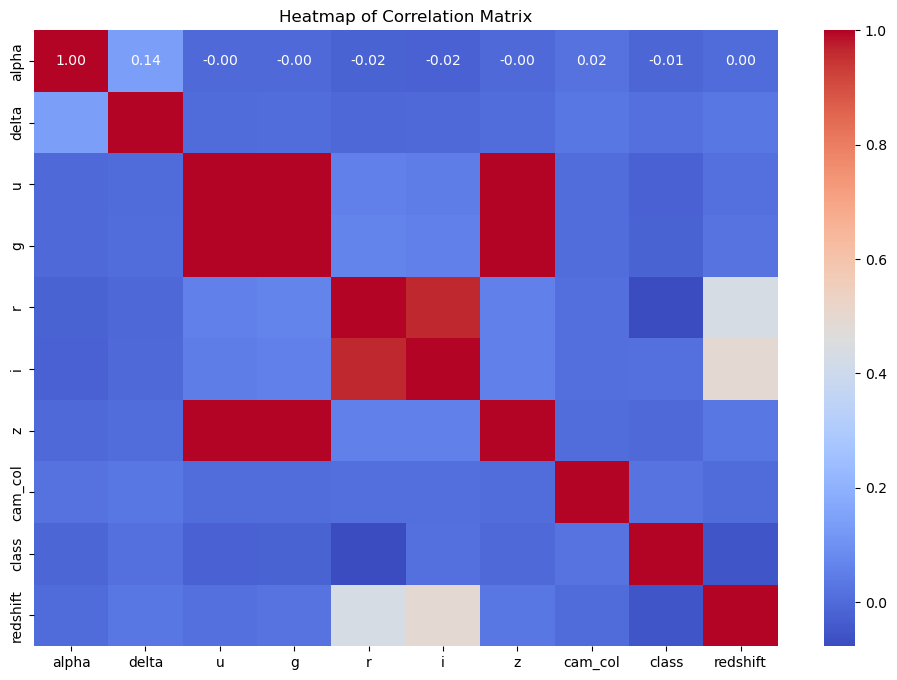

In [25]:
correlation_matrix = data.corr()

plt.figure(figsize=(12, 8))  # Create a plot using matplotlib
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # Create a plot using seaborn
plt.title('Heatmap of Correlation Matrix')  # Create a plot using matplotlib
plt.show()  # Create a plot using matplotlib

Feature importances:
 redshift    0.650296
z           0.090465
g           0.067159
i           0.066356
u           0.060929
r           0.037916
alpha       0.012160
delta       0.011715
cam_col     0.003004
dtype: float64


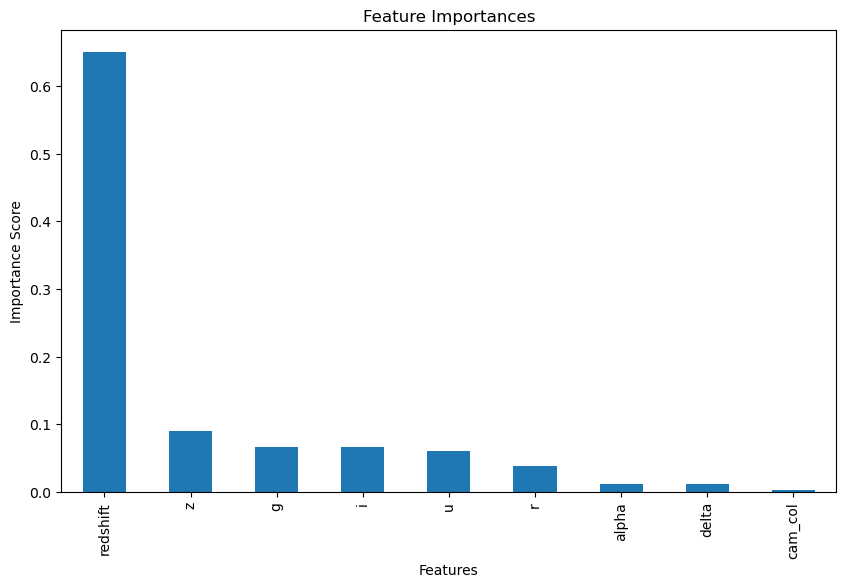

In [17]:
feature_importances = pd.Series(rf_optimized.feature_importances_, index=X_train.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

print("Feature importances:\n", sorted_feature_importances)

import matplotlib.pyplot as plt  # Import necessary libraries

plt.figure(figsize=(10, 6))  # Create a plot using matplotlib
sorted_feature_importances.plot(kind='bar')
plt.title('Feature Importances')  # Create a plot using matplotlib
plt.xlabel('Features')  # Create a plot using matplotlib
plt.ylabel('Importance Score')  # Create a plot using matplotlib
plt.show()  # Create a plot using matplotlib

# Cluster Analysis for Star Classification

## Methodology
- Original data: 3 star classes
- Method: K-means clustering (2-15 clusters)
- Evaluation: Elbow method and Silhouette analysis

## Results
- Initial automatic selection: 2 clusters
- Visual analysis of plots: 3 clusters (matching original classes)

## Key Observations
1. Elbow plot shows a significant bend at 3 clusters
2. Silhouette score has a clear peak at 3 clusters
3. Visual analysis aligns with the original number of classes

## Conclusion
Despite the initial automatic selection of 2 clusters, visual inspection of the Elbow and Silhouette plots strongly suggests 3 as the optimal number of clusters. This matches the original classification in the dataset, indicating that the clustering algorithm can effectively identify the inherent structure in the data when properly interpreted.



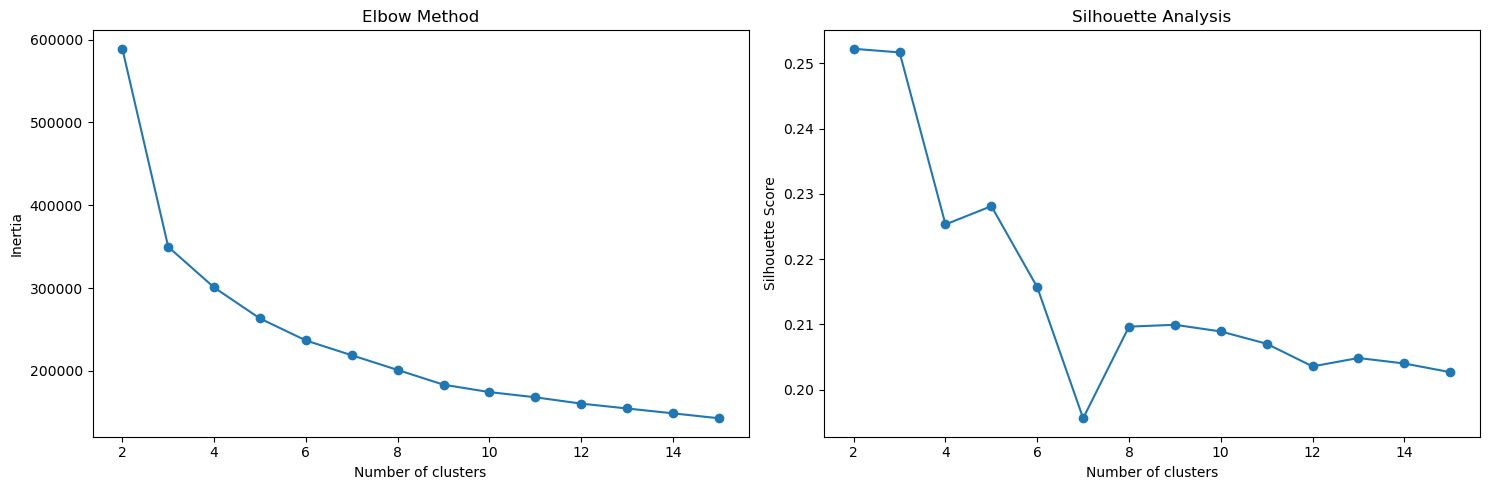

Optimal number of clusters based on silhouette score: 2

Cluster composition:
class      0      1      2
row_0                     
0      28532  14473   6998
1      19053    691  10253

Cluster characteristics:
      alpha     delta         u         g         r         i         z  \
0 -0.002972  0.025762  0.033211  0.038637  0.654876  0.640998  0.034281   
1  0.004976 -0.043139 -0.055612 -0.064699 -1.096598 -1.073359 -0.057404   

    cam_col  redshift  Most Common Class  Cluster Size  
0  0.008740  0.367277                  0         50003  
1 -0.014635 -0.615010                  0         29997  

Number of original classes: 3
Number of detected clusters: 2
Some classes might be combined in clusters.


In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  # Import necessary libraries
import numpy as np  # Import necessary libraries
import pandas as pd  # Import necessary libraries

def analyze_clusters(X, y, max_clusters=15):
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Calculate inertia and silhouette scores for different numbers of clusters
    inertias = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)  # Train the model on the training data
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    # Plot elbow curve and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(range(2, max_clusters + 1), inertias, marker='o')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    
    plt.tight_layout()  # Create a plot using matplotlib
    plt.show()  # Create a plot using matplotlib

    # Determine optimal number of clusters
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")

    # Perform K-means clustering with optimal number of clusters
    kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans_optimal.fit_predict(X_scaled)  # Make predictions using the trained model

    # Analyze cluster composition
    cluster_composition = pd.crosstab(cluster_labels, y)
    print("\nCluster composition:")
    print(cluster_composition)

    # Analyze cluster characteristics
    cluster_centers = scaler.inverse_transform(kmeans_optimal.cluster_centers_)
    cluster_df = pd.DataFrame(cluster_centers, columns=X.columns)
    cluster_df['Most Common Class'] = [cluster_composition.idxmax()[i] for i in range(optimal_clusters)]
    cluster_df['Cluster Size'] = cluster_composition.sum(axis=1)
    
    print("\nCluster characteristics:")
    print(cluster_df)

    return cluster_labels, optimal_clusters

# Use the function
cluster_labels, optimal_clusters = analyze_clusters(X_train, y_train)

# Compare number of clusters with number of original classes
original_classes = len(np.unique(y_train))
print(f"\nNumber of original classes: {original_classes}")
print(f"Number of detected clusters: {optimal_clusters}")

if optimal_clusters > original_classes:
    print("Potential new clusters detected!")
    # Analyze the extra clusters
    for cluster in range(original_classes, optimal_clusters):
        cluster_mask = cluster_labels == cluster
        cluster_data = X_train[cluster_mask]
        print(f"\nAnalysis of potential new cluster {cluster}:")
        print(f"Cluster size: {cluster_data.shape[0]}")
        print("Average feature values:")
        print(cluster_data.mean())
elif optimal_clusters < original_classes:
    print("Some classes might be combined in clusters.")
else:
    print("Number of clusters matches number of original classes.")

In [20]:
pip install pykan


   ---------------------------------------- 0.0/95.2 kB ? eta -:--:--
   -------- ------------------------------- 20.5/95.2 kB 682.7 kB/s eta 0:00:01
   ----------------- ---------------------- 41.0/95.2 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 95.2/95.2 kB 679.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch
from kan import *


checkpoint directory created: ./model
saving model version 0.0
Epoch [100/1000], Loss: 0.7232
Epoch [200/1000], Loss: 0.4629
Epoch [300/1000], Loss: 0.2917
Epoch [400/1000], Loss: 0.2173
Epoch [500/1000], Loss: 0.1805
Epoch [600/1000], Loss: 0.1579
Epoch [700/1000], Loss: 0.1411
Epoch [800/1000], Loss: 0.1285
Epoch [900/1000], Loss: 0.1192
Epoch [1000/1000], Loss: 0.1125
Model trained


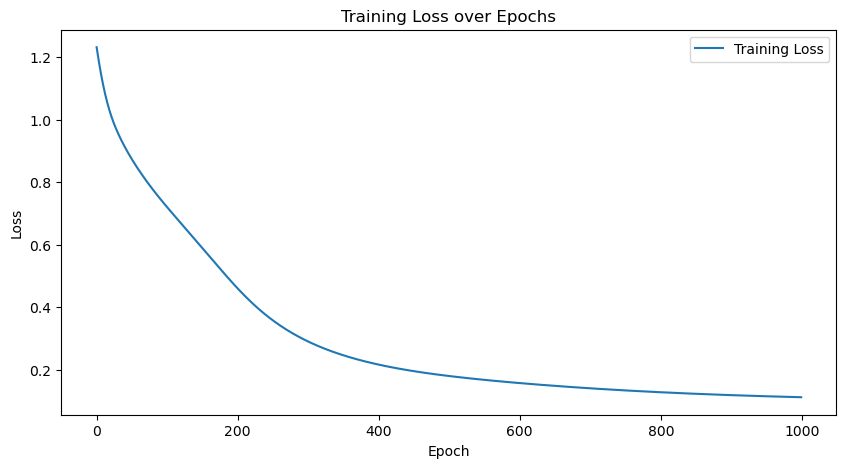

In [22]:
model = KAN(width=[X_train.shape[1], 10, len(set(y_train))], grid=5, k=3)

# Data preparation for PyTorch
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

# Defining optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# List to store loss values
loss_values = []

# Model training
model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Saving loss value
    loss_values.append(loss.item())

    # Print information about the current epoch and loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/1000], Loss: {loss.item():.4f}")

print("Model trained")

# Plotting the loss function
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


In [23]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred_kan = torch.argmax(y_pred_tensor, axis=1).numpy()

# Model evaluation
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred_kan))
print("Classification Report:\n", classification_report(y_test, y_pred_kan))

Accuracy: 0.96625
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     11860
           1       0.96      0.90      0.93      3797
           2       0.96      1.00      0.98      4343

    accuracy                           0.97     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000

